In [83]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

In [2]:
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

In [74]:
observation_noise_variance = 0.1

def f(x):
    y = np.cos(10*x) #( np.sin(10*x) + np.cos(5*x) ) * np.exp(-x**2)
    return np.ravel(y)

observation_index_points = np.random.uniform(-1, 1, [50, 1])

observations = (f(observation_index_points) + np.random.normal(0., np.sqrt(observation_noise_variance)))


In [75]:
f(observation_index_points).shape

(50,)

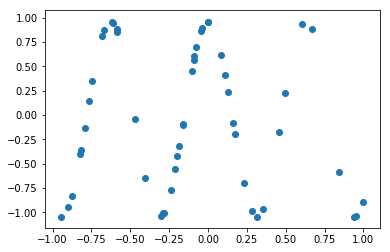

In [76]:
plt.scatter(observation_index_points, observations)

In [122]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')

kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

In [129]:
observation_noise_variance = tf.exp(tf.Variable(np.float64(-0.3)), name='observation_noise_variance')

In [130]:
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

In [131]:
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=0.08)#, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

In [132]:
index_points = np.linspace(-1.5, 1.5, 200).reshape(-1,1)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)

Step 0: NLL = 59.02064225468976
Step 100: NLL = 54.960844520357014
Step 200: NLL = -160.46581487298332
Step 300: NLL = -191.12724236347137
Step 400: NLL = -191.76610282786774
Step 500: NLL = -191.9741477352732
Step 600: NLL = -192.07503488283268
Step 700: NLL = -192.13541715233265
Step 800: NLL = -192.1729313391432
Step 900: NLL = -192.20013903856773
Final NLL = -192.21918403212808

Trained parameters:
amplitude: 3.316833900855297
length_scale: 0.30436992961876913
observation_noise_variance: 5.4925095570612215e-09


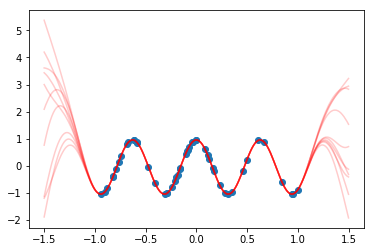

In [133]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
        if i % 100 == 0:
            print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    
    amplitude_, length_scale_, observation_noise_variance_ = sess.run([amplitude,length_scale, observation_noise_variance])
    
    
    samples_ = sess.run(samples)
    
print('\nTrained parameters:'.format(amplitude_))
print('amplitude: {}'.format(amplitude_))
print('length_scale: {}'.format(length_scale_))
print('observation_noise_variance: {}'.format(observation_noise_variance_))

plt.scatter(np.squeeze(observation_index_points), observations)    
plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)
plt.show()